# Leakage-Aware Decoding with LCD Demo

*Want to follow along? {nb-download}`Download this notebook.<leakage_demo.ipynb>`*

In this notebook, we briefly demonstrate Leakage functionality. In particular, we define a leakage noise model and add this to a generated surface code circuit. We then perform decoding with Riverlane's [Local Clustering Decoder (LCD)](https://arxiv.org/pdf/2411.10343), benchmarking leakage-aware decoding against leakage-unaware decoding.
## Necessary imports

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
from deltakit.explorer import Logging, Client, enums, types

Logging.set_log_to_console(False)
client = Client.get_instance()
data_folder = Path("../..") / "data"

## Circuit generation and leakage noise

In [2]:
distance = 5

# Generate a surface code circuit
compiled_circuit = client.generate_circuit(
      types.QECExperimentDefinition.get_rotated_planar_z_quantum_memory(
            distance=distance,
            num_rounds=distance,
            basis_gates=["CZ", "H", "MZ", "RZ"],
      )
)

Define [SI1000](https://arxiv.org/abs/2108.10457)+leakage noise model, where $p$ is the physical error rate and $p_l$ is the probability a 2-qubit gate causes a qubit to leak.

In [3]:
leakage_noise_model = types.SI1000NoiseModel(p=0.001, p_l=0.001)

# Add leakage noise to circuit
noisy_circuit = client.add_noise(
      stim_circuit=compiled_circuit,
      noise_model=leakage_noise_model,
)

## Simulation and leakage-aware decoding

In [4]:
def simulate_and_decode(
    noisy_circuit: str,
    num_shots: int,
    leakage_aware: bool,
    weighted: bool
) -> types.DecodingResult:
    # Circuit simulation
    measurements, leakage = client.simulate_stim_circuit(
        stim_circuit=noisy_circuit,
        shots=num_shots,
    )
    # Obtaining detector and observable data
    detectors, observables = measurements.to_detectors_and_observables(noisy_circuit)

    decoder = types.Decoder(
        decoder_type=enums.DecoderType.LCD,
        parameters={"weighted": weighted} if leakage_aware else None,
        parallel_jobs=4,
        use_experimental_graph=False,
    )
    # Decoding — providing leakage data with LCD allows for leakage-aware decoding
    return client.decode(
            detectors=detectors,
            observables=observables,
            decoder=decoder,
            noisy_stim_circuit=noisy_circuit,
            leakage_flags=leakage if leakage_aware else None,
    )

In [5]:
num_shots = 100000
rounds = [1, 3, 5]
decoding_experiments = {"leakage_unaware" : (False, False),
                        "leakage_aware" : (True, False),
                        "weighted_leakage_aware" : (True, True)}

results_dict = {key: [] for key in decoding_experiments}
errors_dict = {key: [] for key in decoding_experiments}

for num_rounds in rounds:
    # Generate a surface code circuit
    compiled_circuit = client.generate_circuit(
        types.QECExperimentDefinition.get_rotated_planar_z_quantum_memory(
            distance=distance,
            num_rounds=num_rounds,
            basis_gates=["CZ", "H", "MZ", "RZ"],
        )
    )
    # Add leakage noise
    noisy_circuit = client.add_noise(
        stim_circuit=compiled_circuit,
        noise_model=leakage_noise_model,
    )

    # Run the experiment with leakage-unaware, leakage-aware, and weighted leakage-aware
    for exp_type, specs in decoding_experiments.items():
        result = simulate_and_decode(noisy_circuit, num_shots, *specs)
        results_dict[exp_type].append(result.get_logical_error_probability())
        errors_dict[exp_type].append(result.get_standard_deviation())

simulation batches: 100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


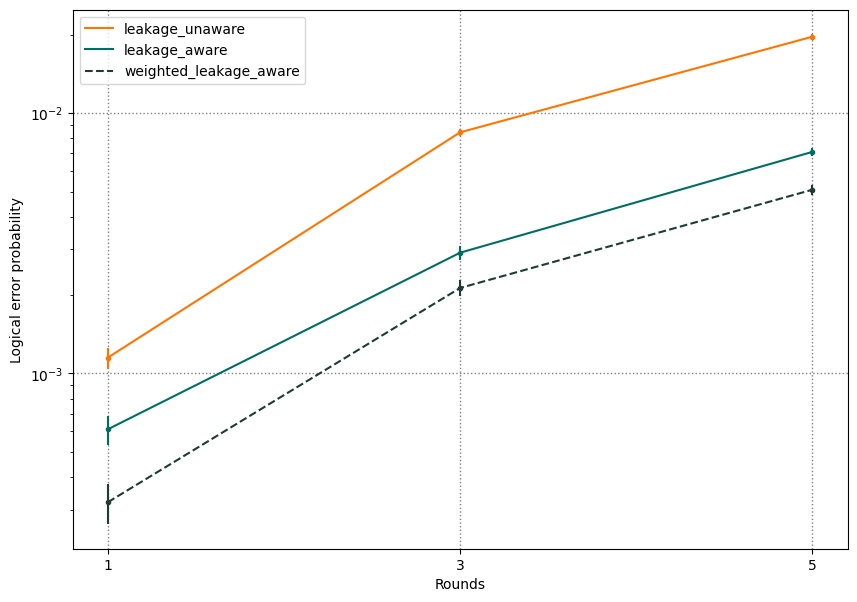

In [6]:
colours = ["#ff7500", "#006f62", "#1d3c34"]
linestyles = [None, None, "--"]

plt.figure(figsize=(10, 7))
plt.grid(color="gray", linestyle=":", linewidth=1)

for i, (key, value) in enumerate(results_dict.items()):
    plt.plot(rounds, value, label=key, color=colours[i], linestyle=linestyles[i])
    plt.errorbar(
        rounds,
        value,
        yerr=errors_dict[key],
        fmt=".",
        color=colours[i],
    )

plt.xticks(rounds)
plt.xlabel("Rounds")
plt.ylabel("Logical error probability")
plt.yscale("log")
plt.legend(fontsize=10)
plt.show()